In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

plt.style.use("./paper.mplstyle")

In [2]:
df_orig = pd.read_table("../data/ref/ag_map_with_alpha.txt.quartiles.tsv", sep="\t", index_col=0)
df_orig.index = "S" + df_orig.index
print(df_orig.shape)
df_orig.head()

(9511, 146)


,center_project_name,extraction_robot,plating,primer_plate,processing_robot,acid_reflux,acne_medication_otc,add_adhd,age_cat,alcohol_consumption,...,vioscreen_erythr,vioscreen_fiber,vioscreen_fol_deqv,vioscreen_formontn,vioscreen_grams,vioscreen_inositol,vioscreen_lutzeax,vioscreen_lycopene,vioscreen_tfa181t,vioscreen_xylitol
#SampleID,,,,,,,,,,,,,,,,,,,,,
S10317.000028848,AG19,NaN,NaN,NaN,NaN,NaN,Yes,"Diagnosed by a medical professional (doctor, p...",30s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000049761,NaN,NaN,NaN,5.0,ROBE,I do not have this condition,No,I do not have this condition,50s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000059054,NaN,HOWE_KF1,LDG,7.0,CARMEN,I do not have this condition,No,I do not have this condition,60s,Yes,...,2.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,1.0,2.0
S10317.000030512,AG25,HOWE_KF2,LDG,6.0,JERE,NaN,No,I do not have this condition,30s,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S10317.000040165,NaN,HOWE_KF1,LDG,5.0,ROBE,NaN,No,I do not have this condition,30s,Yes,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0


In [3]:
## Remap since some failed

cond_map = {
    "I do not have this condition": "No",
    "Diagnosed by a medical professional (doctor, physician assistant)": "Yes",
    "Self-diagnosed": np.nan,
    "Diagnosed by an alternative medicine practitioner": np.nan,
}

def replace_cond(item_1):
    if item_1 in cond_map:
        return cond_map[item_1]
    else:
        return item_1
    
q_map = {0.0: "q1", 1.0: "q2", 2.0: "q3", 3.0: "q4"}
    
for col in df_orig:
    df_orig[col] = df_orig[col].map(replace_cond)
    if set(df_orig[col].dropna().unique()) == {0.0, 1.0, 2.0, 3.0}:
        df_orig[col] = df_orig[col].map(q_map)

print(df_orig.shape)

(9511, 146)


In [4]:
agp_results = pd.read_excel(
    "../data/ref/sys003182229st2.xlsx",
    sheet_name="Effect size, unweighted UniFrac",
    header=0
)
agp_results[["group_1", "group_2"]] = agp_results["effect_size_values"].str.split(" vs. ", expand=True)
q_map = {"0.0": "q1", "1.0": "q2", "2.0": "q3", "3.0": "q4"}
agp_results["group_1"] = agp_results["group_1"].replace(q_map)
agp_results["group_2"] = agp_results["group_2"].replace(q_map)

agp_results["group_1"] = agp_results["group_1"].map(replace_cond)
agp_results["group_2"] = agp_results["group_2"].map(replace_cond)

agp_results = agp_results.replace({"Child": "child"})

print(agp_results.shape)
agp_results.head()

(113, 8)


,column_name,effect_size,effect_size_square,effect_size_values,pval_corrected,pval,group_1,group_2
0,age_cat,0.616142,0.379631,Child vs. 60s,0.000323,0.0002,child,60s
1,center_project_name,0.497663,0.247668,AG1 vs. AG23,0.000323,0.0002,AG1,AG23
2,antibiotic_history,0.388949,0.151281,Month vs. I have not taken antibiotics in the ...,0.000323,0.0002,Month,I have not taken antibiotics in the past year.
3,processing_robot,0.387074,0.149826,RikE vs. LUCY,0.000323,0.0002,RikE,LUCY
4,prepared_meals_frequency,0.375348,0.140886,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never


In [5]:
na_vals = ["Not provided"]
df_new = pd.read_table("../data/processed/metadata.disambig.filt.tsv", sep="\t", index_col=0,
                       na_values=na_vals)
print(df_new.shape)
df_new.head()

(9511, 94)


,specialized_diet_other_restrictions_not_described_here,collection_month,deodorant_use,non_food_allergies_pet_dander,milk_substitute_frequency,cardiovascular_disease,sleep_duration,teethbrushing_frequency,specialized_diet_westenprice_or_other_lowgrain_low_processed_fo,gluten,...,vegetable_frequency,lung_disease,multivitamin,contraceptive,olive_oil,mental_illness_type_ptsd_posttraumatic_stress_disorder,cat,race,cosmetics_frequency,antibiotic_history
#SampleID,,,,,,,,,,,,,,,,,,,,,
S10317.000040354.128811,NaN,February,I do not use deodorant or an antiperspirant,No,Never,No,6-7 hours,Daily,NaN,I do not eat gluten because it makes me feel bad,...,Daily,Yes,No,No,Occasionally (1-2 times/week),No,No,Caucasian,Occasionally (1-2 times/week),I have not taken antibiotics in the past year.
S10317.000058845.129642,No,November,I use deodorant,No,Rarely (less than once/week),No,7-8 hours,Daily,No,No,...,Regularly (3-5 times/week),No,Yes,No,Regularly (3-5 times/week),No,No,Caucasian,Daily,Year
S10317.000009549.127000,NaN,August,I do not use deodorant or an antiperspirant,No,NaN,NaN,6-7 hours,Daily,NaN,No,...,NaN,No,No,NaN,NaN,NaN,No,Caucasian,Never,Year
S10317.000006134.129242,NaN,August,I do not use deodorant or an antiperspirant,No,NaN,NaN,8 or more hours,Daily,NaN,NaN,...,NaN,No,Yes,NaN,NaN,NaN,No,Caucasian,Never,I have not taken antibiotics in the past year.
S10317.000039521.129675,NaN,November,I use an antiperspirant,No,Daily,No,6-7 hours,Daily,NaN,No,...,Regularly (3-5 times/week),No,No,No,Regularly (3-5 times/week),No,Yes,Caucasian,Never,I have not taken antibiotics in the past year.


In [6]:
set(agp_results["column_name"]).difference(df_new.columns)

{'age_cat',
 'alcohol_consumption',
 'alcohol_types_beercider',
 'alcohol_types_red_wine',
 'alcohol_types_spiritshard_alcohol',
 'alcohol_types_white_wine',
 'allergic_to_i_have_no_food_allergies_that_i_know_of',
 'bmi_corrected',
 'elevation',
 'height_cm',
 'latitude',
 'longitude',
 'roommates',
 'vioscreen_a_bev',
 'vioscreen_add_sug',
 'vioscreen_alphacar',
 'vioscreen_alphtoce',
 'vioscreen_avcarb',
 'vioscreen_betacryp',
 'vioscreen_biochana',
 'vioscreen_caffeine',
 'vioscreen_calcium',
 'vioscreen_copper',
 'vioscreen_d_cheese',
 'vioscreen_erythr',
 'vioscreen_f_citmlb',
 'vioscreen_fiber',
 'vioscreen_fol_deqv',
 'vioscreen_formontn',
 'vioscreen_g_whl',
 'vioscreen_grams',
 'vioscreen_inositol',
 'vioscreen_lutzeax',
 'vioscreen_lycopene',
 'vioscreen_m_fish_hi',
 'vioscreen_m_frank',
 'vioscreen_m_meat',
 'vioscreen_m_mpf',
 'vioscreen_salad_vegetable_servings',
 'vioscreen_tfa181t',
 'vioscreen_xylitol',
 'weight_corrected'}

In [7]:
pw_new = pd.read_table("../results/beta_pairwise_effect_size_by_cat.tsv",
                       sep="\t", index_col=0).dropna()

pw_new["group_1"] = pw_new["group_1"].replace({"Child": "child"})
pw_new["group_2"] = pw_new["group_2"].replace({"Child": "child"})

_dfs = []
for i, row in agp_results.iterrows():
    g1, g2 = row[["group_1", "group_2"]]
    x = pw_new[
        (((pw_new["group_1"] == g1) & (pw_new["group_2"] == g2))
        | ((pw_new["group_1"] == g2) & (pw_new["group_2"] == g1)))
        & (pw_new["column"] == row["column_name"])
    ]
    _dfs.append(x)
    
evident_df_new = pd.concat(_dfs).reset_index(drop=True)
print(evident_df_new.shape)
evident_df_new.head()

(70, 5)


,effect_size,metric,column,group_1,group_2
0,0.103310,cohens_d,center_project_name,AG1,AG23
1,0.417409,cohens_d,antibiotic_history,I have not taken antibiotics in the past year.,Month
2,0.407101,cohens_d,processing_robot,LUCY,RikE
3,0.350438,cohens_d,prepared_meals_frequency,Never,Occasionally (1-2 times/week)
4,0.307478,cohens_d,race,Asian or Pacific Islander,Caucasian


In [8]:
comp_df_agp_new = (
    agp_results.set_index("column_name")
    .join(evident_df_new.set_index("column"), lsuffix="_agp", rsuffix="_evident", how="inner")
)
comp_df_agp_new = comp_df_agp_new.drop(index=["center_project_name"])
comp_df_agp_new["es_diff"] = comp_df_agp_new["effect_size_agp"] - comp_df_agp_new["effect_size_evident"]
comp_df_agp_new["es_diff_abs"] = np.abs(comp_df_agp_new["es_diff"])
comp_df_agp_new = comp_df_agp_new.sort_values(by="es_diff_abs", ascending=False)
print(comp_df_agp_new.shape)
comp_df_agp_new.head(10)

(69, 13)


,effect_size_agp,effect_size_square,effect_size_values,pval_corrected,pval,group_1_agp,group_2_agp,effect_size_evident,metric,group_1_evident,group_2_evident,es_diff,es_diff_abs
contraceptive,0.125246,0.015687,"No vs. Yes, I am taking the ""pill""",0.000323,0.0002,No,"Yes, I am taking the ""pill""",0.054820,cohens_d,No,"Yes, I am taking the ""pill""",0.070426,0.070426
homecooked_meals_frequency,0.100685,0.010137,Daily vs. Occasionally (1-2 times/week),0.000323,0.0002,Daily,Occasionally (1-2 times/week),0.039280,cohens_d,Daily,Occasionally (1-2 times/week),0.061404,0.061404
race,0.366027,0.133976,Caucasian vs. Asian or Pacific Islander,0.000323,0.0002,Caucasian,Asian or Pacific Islander,0.307478,cohens_d,Asian or Pacific Islander,Caucasian,0.058549,0.058549
fermented_plant_frequency,0.145931,0.021296,Rarely (less than once/week) vs. Daily,0.000323,0.0002,Rarely (less than once/week),Daily,0.094217,cohens_d,Daily,Rarely (less than once/week),0.051715,0.051715
ready_to_eat_meals_frequency,0.183763,0.033769,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.139214,cohens_d,Never,Regularly (3-5 times/week),0.044549,0.044549
chickenpox,0.056315,0.003171,No vs. Yes,0.000323,0.0002,No,Yes,0.015546,cohens_d,No,Yes,0.040769,0.040769
acne_medication_otc,0.071467,0.005108,No vs. Yes,0.000323,0.0002,No,Yes,0.033537,cohens_d,No,Yes,0.037931,0.037931
milk_substitute_frequency,0.129965,0.016891,Rarely (less than once/week) vs. Daily,0.000323,0.0002,Rarely (less than once/week),Daily,0.093202,cohens_d,Daily,Rarely (less than once/week),0.036762,0.036762
meat_eggs_frequency,0.169700,0.028798,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.200254,cohens_d,Never,Regularly (3-5 times/week),-0.030554,0.030554
olive_oil,0.181855,0.033071,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.211680,cohens_d,Never,Regularly (3-5 times/week),-0.029825,0.029825


In [9]:
comp_df_agp_new.sort_values(by="effect_size_evident", ascending=False).head()

,effect_size_agp,effect_size_square,effect_size_values,pval_corrected,pval,group_1_agp,group_2_agp,effect_size_evident,metric,group_1_evident,group_2_evident,es_diff,es_diff_abs
antibiotic_history,0.388949,0.151281,Month vs. I have not taken antibiotics in the ...,0.000323,0.0002,Month,I have not taken antibiotics in the past year.,0.417409,cohens_d,I have not taken antibiotics in the past year.,Month,-0.028460,0.028460
processing_robot,0.387074,0.149826,RikE vs. LUCY,0.000323,0.0002,RikE,LUCY,0.407101,cohens_d,LUCY,RikE,-0.020027,0.020027
prepared_meals_frequency,0.375348,0.140886,Occasionally (1-2 times/week) vs. Never,0.000323,0.0002,Occasionally (1-2 times/week),Never,0.350438,cohens_d,Never,Occasionally (1-2 times/week),0.024911,0.024911
country,0.319858,0.102309,United Kingdom vs. USA,0.000323,0.0002,United Kingdom,USA,0.340109,cohens_d,USA,United Kingdom,-0.020251,0.020251
salted_snacks_frequency,0.345779,0.119563,Regularly (3-5 times/week) vs. Never,0.000323,0.0002,Regularly (3-5 times/week),Never,0.321925,cohens_d,Never,Regularly (3-5 times/week),0.023853,0.023853


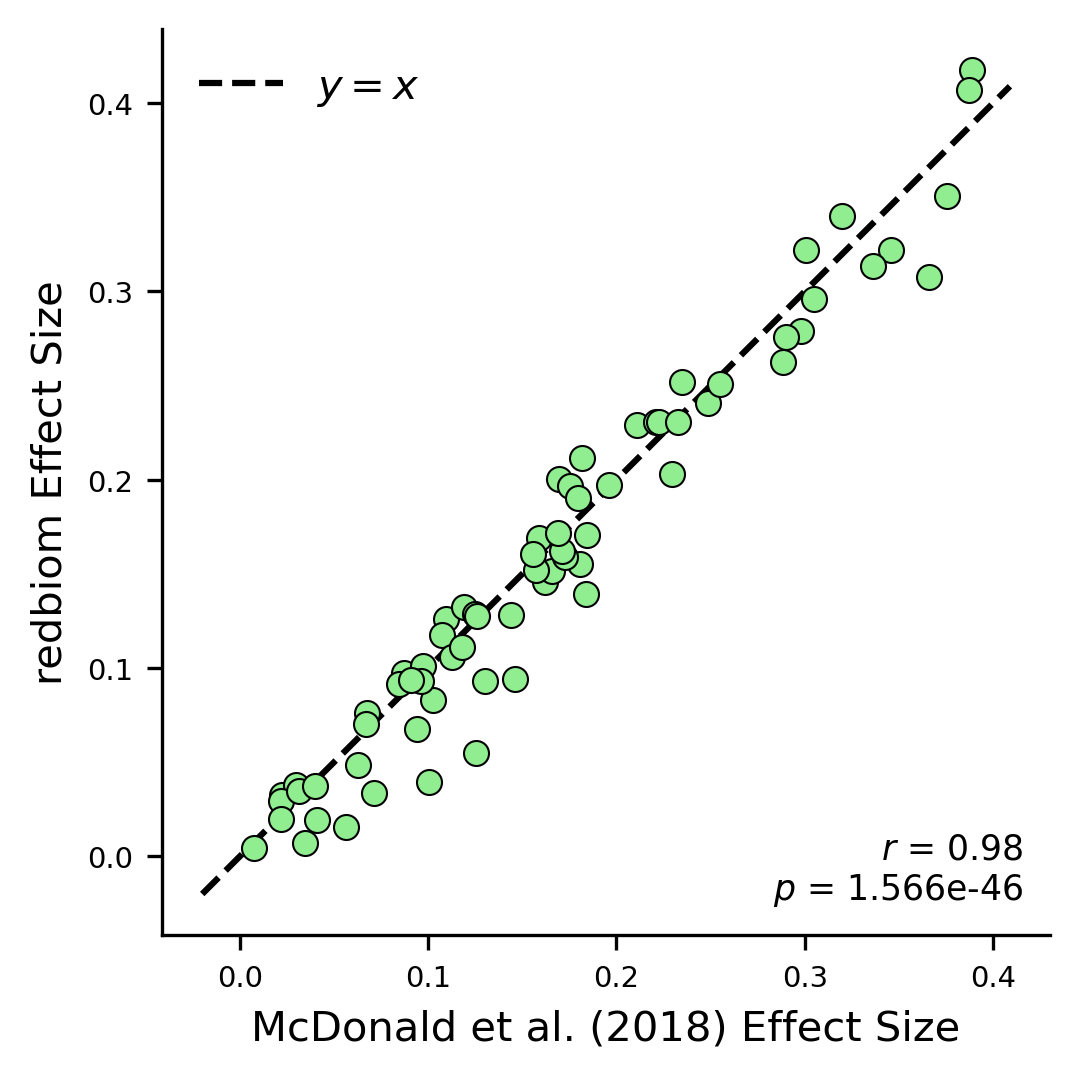

In [10]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")

sns.scatterplot(
    data=comp_df_agp_new,
    x="effect_size_agp",
    y="effect_size_evident",
    linewidth=0.5,
    color="lightgreen",
    edgecolor="black",
    ax=ax
)

max_val = min(comp_df_agp_new["effect_size_agp"].max(), comp_df_agp_new["effect_size_evident"].max())
ax.plot(
    [0-0.02, max_val+0.02], [0-0.02, max_val+0.02],
    color="black",
    ls="--",
    zorder=0
)

ax.set_xlabel("McDonald et al. (2018) Effect Size")
ax.set_ylabel("redbiom Effect Size")

r, pval = ss.pearsonr(comp_df_agp_new["effect_size_agp"], comp_df_agp_new["effect_size_evident"])
ax.text(
    x=0.97,
    y=0.03,
    s=f"$r$ = {r:.2f}\n$p$ = {pval:.3e}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    size="small"
)
ax.tick_params("both", labelsize="x-small")

y_eq_x_patch = Line2D([0], [0], ls="--", color="black", label = "$y = x$")
ax.legend(
    handles=[y_eq_x_patch],
    frameon=False
)

plt.savefig("../figures/redbiom_vs_published.pdf")
plt.show()

In [11]:
es_df = pd.read_table("../results/beta_effect_size_by_cat.tsv", sep="\t", index_col=0).dropna()
print(es_df.shape)
es_df.head(10)

(91, 3)


,effect_size,metric,column
0,0.322438,cohens_d,mental_illness_type_ptsd_posttraumatic_stress_...
1,0.275675,cohens_d,fungal_overgrowth
2,0.240522,cohens_d,specialized_diet_exclude_refined_sugars
3,0.197043,cohens_d,autoimmune
4,0.190181,cohens_d,clinical_condition
5,0.162312,cohens_d,other_supplement_frequency
6,0.158541,cohens_d,specialized_diet_other_restrictions_not_descri...
7,0.132565,cohens_d,multivitamin
8,0.127983,cohens_d,lactose
9,0.111283,cohens_d,nail_biter


In [12]:
pa_df = pd.read_table("../results/power_analysis.tsv", sep="\t")
print(pa_df.shape)
pa_df.head()

(10716, 7)


,alpha,total_observations,power,effect_size,difference,metric,column
0,0.01,20,0.014021,0.158541,NaN,cohens_d,specialized_diet_other_restrictions_not_descri...
1,0.05,20,0.063030,0.158541,NaN,cohens_d,specialized_diet_other_restrictions_not_descri...
2,0.10,20,0.119701,0.158541,NaN,cohens_d,specialized_diet_other_restrictions_not_descri...
3,0.01,60,0.024658,0.158541,NaN,cohens_d,specialized_diet_other_restrictions_not_descri...
4,0.05,60,0.092717,0.158541,NaN,cohens_d,specialized_diet_other_restrictions_not_descri...


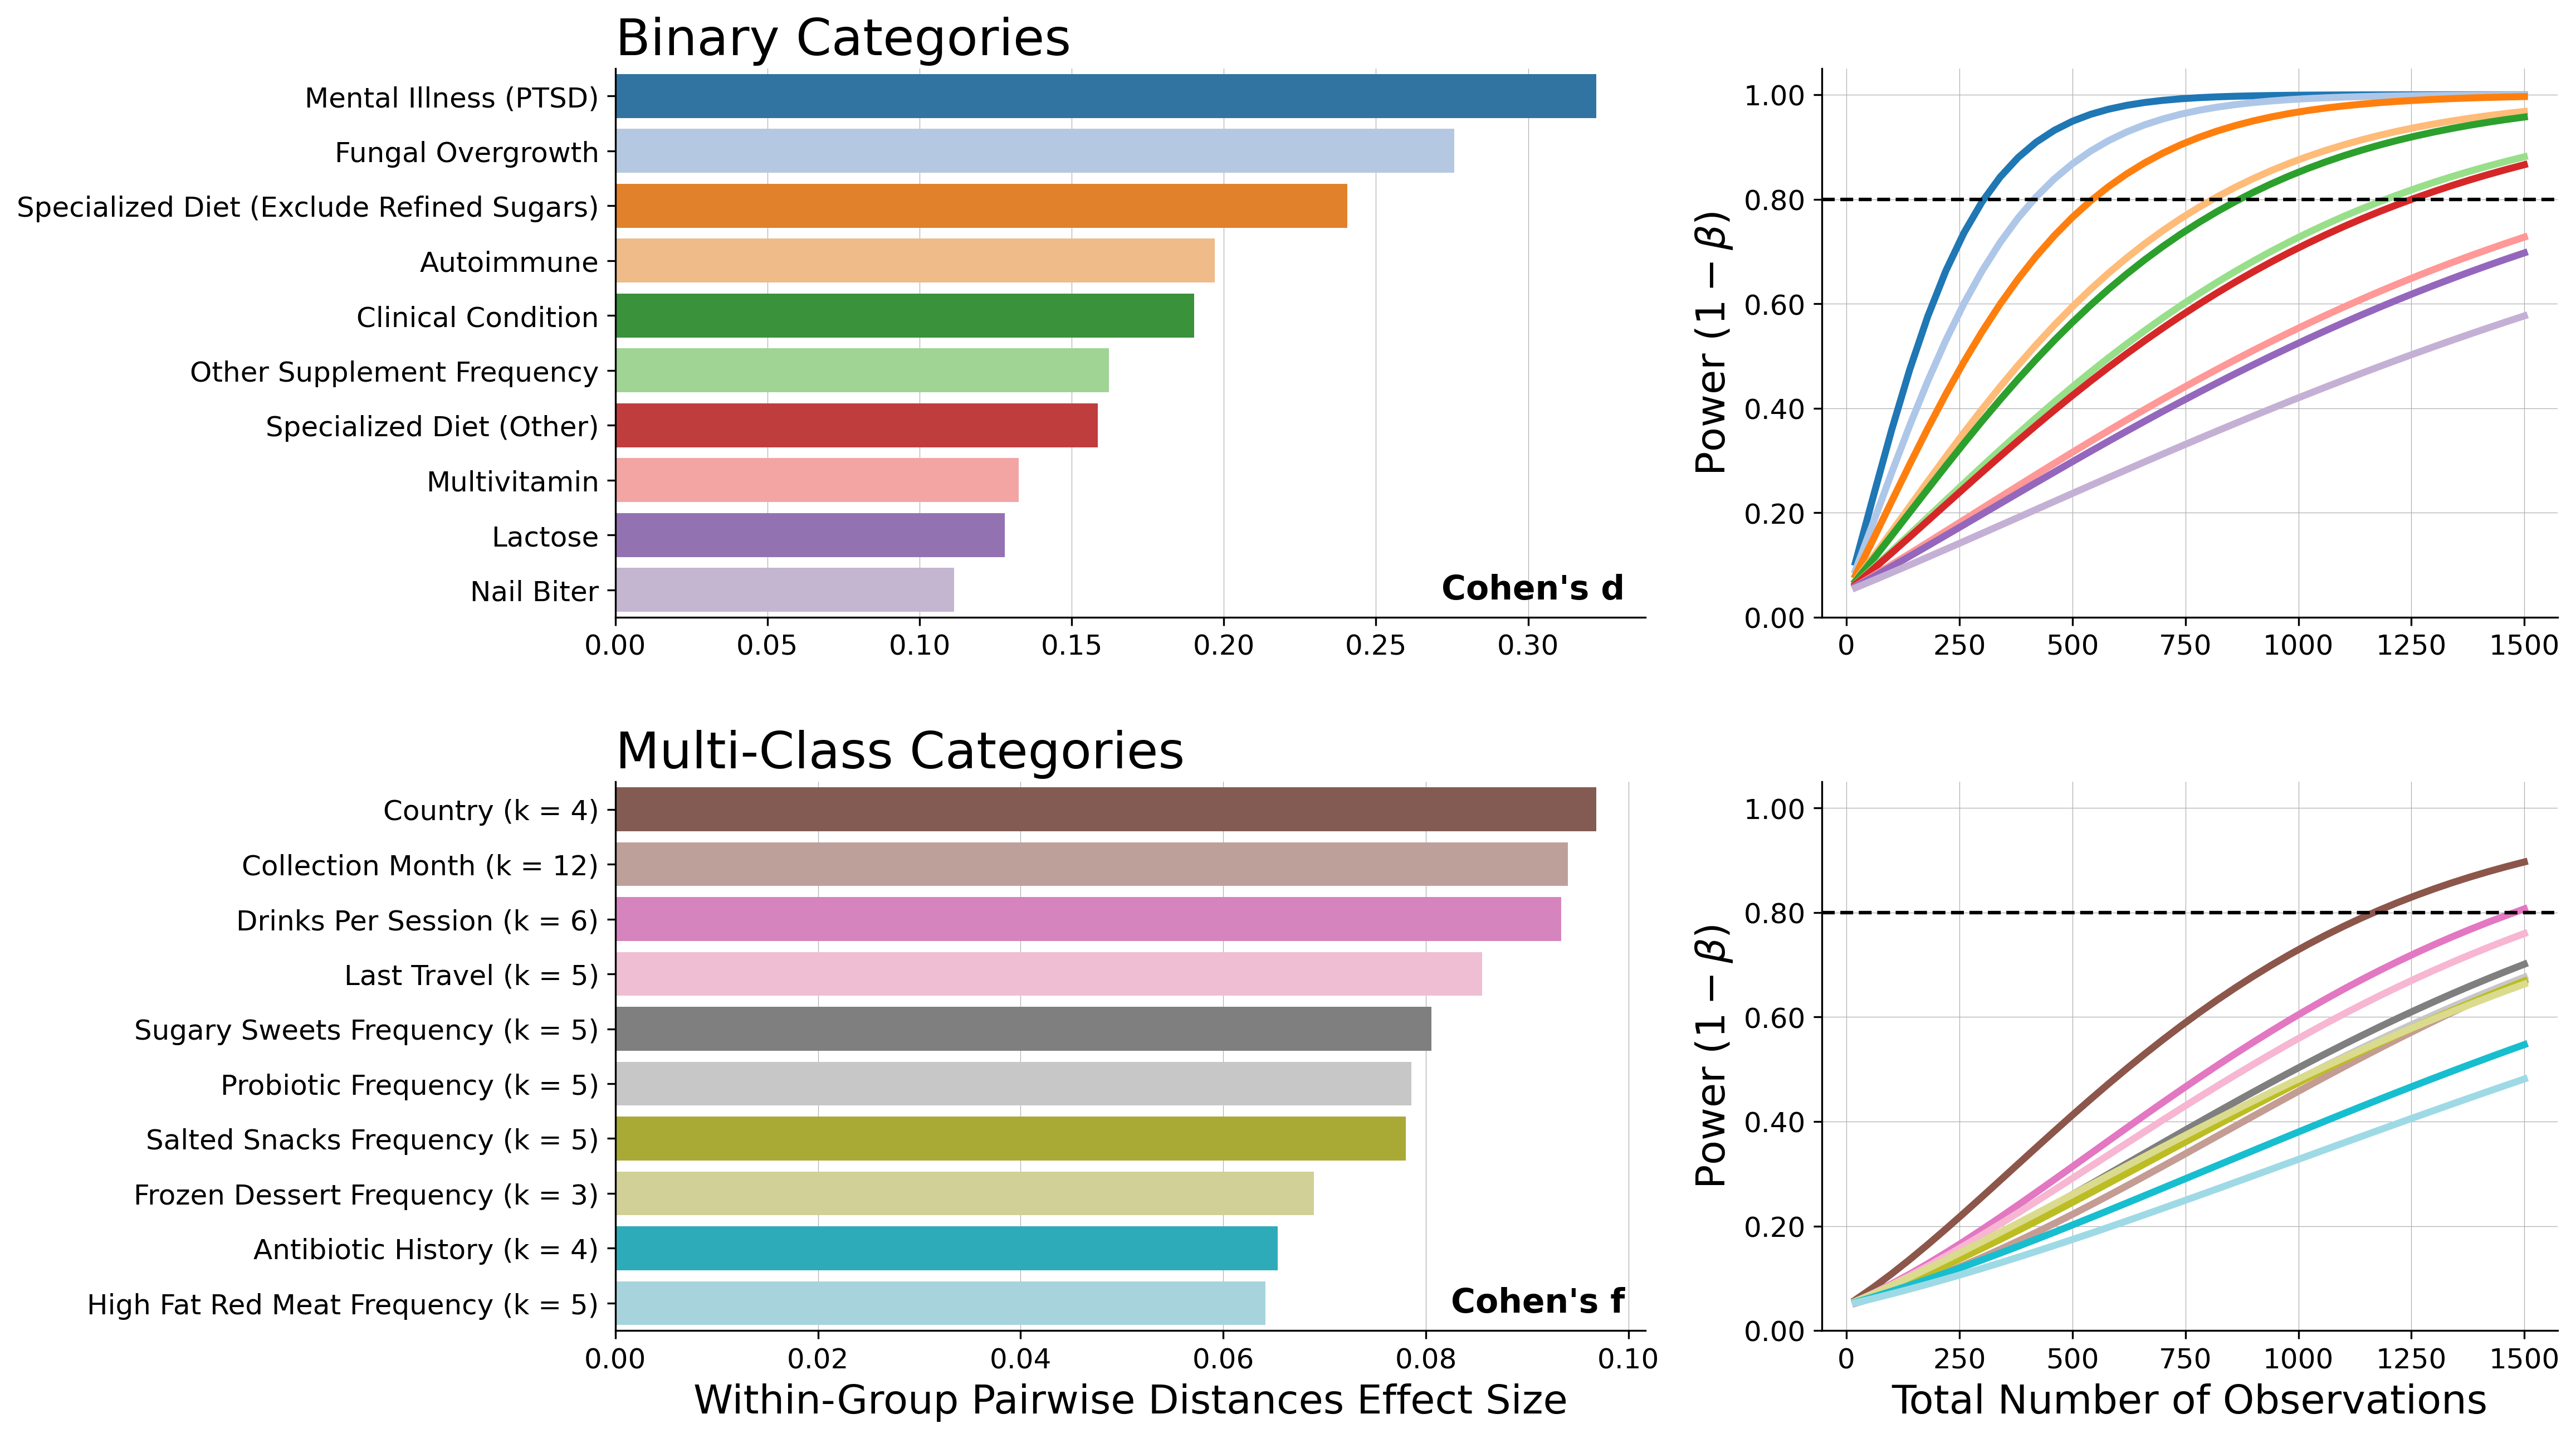

In [13]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[1.4, 1], hspace=0.3)
bar_ax_d, pwr_ax_d = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
bar_ax_f, pwr_ax_f = fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])

n = 10
alpha = 0.05

_es_df_d = es_df.query("metric == 'cohens_d'").head(n)
order_d = _es_df_d["column"]

_es_df_f = es_df.query("metric == 'cohens_f'").head(n)
order_f = _es_df_f["column"]

_pa_df_d = pa_df.query("metric == 'cohens_d' & alpha == @alpha")
_pa_df_d = _pa_df_d[_pa_df_d["column"].isin(order_d)]

_pa_df_f = pa_df.query("metric == 'cohens_f' & alpha == @alpha")
_pa_df_f = _pa_df_f[_pa_df_f["column"].isin(order_f)]

top_cols = order_d.tolist() + order_f.tolist()
cmap = dict(zip(top_cols, sns.color_palette("tab20", n*2)))

bar_args = {"y": "column", "x": "effect_size", "palette": cmap}
text_args = {"x": 0.98, "y": 0.02, "ha": "right", "va": "bottom", "weight": "bold",
             "fontsize": "x-large"}

sns.barplot(**bar_args, data=_es_df_d, ax=bar_ax_d)
bar_ax_d.set_xlabel("")
bar_ax_d.text(**text_args, s="Cohen's d", transform=bar_ax_d.transAxes)

sns.barplot(**bar_args, data=_es_df_f, ax=bar_ax_f)
bar_ax_f.text(**text_args, s="Cohen's f", transform=bar_ax_f.transAxes)
bar_ax_f.set_xlabel("Within-Group Pairwise Distances Effect Size")

col_map = {
    "mental_illness_type_ptsd_posttraumatic_stress_disorder": "Mental Illness (PTSD)",
    "specialized_diet_exclude_refined_sugars": "Specialized Diet (Exclude Refined Sugars)",
    "specialized_diet_other_restrictions_not_described_here": "Specialized Diet (Other)"
    
}

for ax in [bar_ax_d, bar_ax_f]:
    new_labels = []
    for ytick_label in ax.get_yticklabels():
        text = ytick_label.get_text()
        k = len(df_new[text].dropna().unique())
        if col_map.get(text):
            text = col_map.get(text)
        else:
            text = text.replace("_", " ").title()
        if k > 2:
            text += f" (k = {k})"
        new_labels.append(text)
    ax.set_yticklabels(new_labels)
    ax.set_ylabel("")

## Power
line_args = {"y": "power", "x": "total_observations", "palette": cmap, "hue": "column",
             "lw": 3, "legend": False}
text_args = {"x": 0.98, "y": 0.02, "ha": "right", "va": "bottom", "weight": "bold",
             "fontsize": "x-large"}

sns.lineplot(**line_args, data=_pa_df_d, ax=pwr_ax_d, hue_order=order_d)
pwr_ax_d.set_xlabel("")

sns.lineplot(**line_args, data=_pa_df_f, ax=pwr_ax_f, hue_order=order_f)
pwr_ax_f.set_xlabel("Total Number of Observations", fontsize="large")

for ax in [pwr_ax_d, pwr_ax_f]:
    ax.set_ylabel(r"Power $(1 - \beta)$", fontsize="xx-large")
    ax.grid(axis="both", lw=0.3)
    ax.set_axisbelow(True)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.axhline(0.8, color="black", ls="--")
    ax.set_ylim([0, 1.05])
    
for ax in [bar_ax_d, bar_ax_f, pwr_ax_d, pwr_ax_f]:
    ax.grid(axis="x", lw=0.3)
    ax.set_axisbelow(True)
    ax.tick_params("both", labelsize="large")
    ax.set_xlabel(ax.get_xlabel(), fontsize="xx-large")
    
title_args = {"loc": "left", "fontsize": 22}
bar_ax_d.set_title("Binary Categories", **title_args)
bar_ax_f.set_title("Multi-Class Categories", **title_args)

plt.savefig("../figures/effect_sizes_and_power.pdf")
plt.show()